# Online Retail dataset
### Additional Dataset Information
This is a [transactional data](https://archive.ics.uci.edu/dataset/352/online+retail) set which contains all the transactions occurring between `01/12/2010` and `09/12/2011` for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

#### Additional Variable Information

* `InvoiceNo`: Invoice number. **Nominal**, a `6-digit` integral number uniquely assigned to each transaction. If this code starts with letter **`'c'`**, it indicates a **cancellation**. 
* `StockCode`: Product (item) code. Nominal, a `5-digit` integral number uniquely assigned to each distinct product.
* `Description`: Product (item) name. **Nominal**.
* `Quantity`: The quantities of each product (item) per transaction. **Numeric**.	
* `InvoiceDate`: Invoice Date and time. **Numeric**, the day and time when each transaction was generated.
* `UnitPrice`: Unit price. **Numeric**, Product price per unit in sterling.
* `CustomerID`: Customer number. **Nominal**, a `5-digit` integral number uniquely assigned to each customer.
* `Country`: Country name. **Nominal**, the name of the country where each customer resides. 

**It's worth noting that the dataset website provides some information that are not correct. For instance, the dataset does not contain variables called `InvoiceNo` and `StockCode`**.

#### Citation
D. Chen. "Online Retail," UCI Machine Learning Repository, 2015. [Online]. Available: https://doi.org/10.24432/C5BW33.

## Import required package

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Dataset
The dataset is downloadable from the website. This makes it possible to analyse the data when offline.

https://archive.ics.uci.edu/static/public/352/online+retail.zip

Alternatively, the following code could be used:

```python 
from ucimlrepo import fetch_ucirepo                               # after using `pip install ucimlrepo` 

online_retail = fetch_ucirepo(id=352)                             # fetch dataset
df = online_retail.data.ids.join(online_retail.data.features)     # DataFrame
```

In [2]:
online_retail = pd.read_excel('./data/Online Retail.xlsx')
print(f'Shape (rows, cols): {online_retail.shape}')
online_retail.head()

Shape (rows, cols): (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


This is a dataset with more than `500,000` rows. Analysing all of it at once would be impossible for those using machine with insufficient memory. It would therefore be practical to work with a sample. However, I am using a laptop with GPU and 64 GB of memory. I'll turn to using sample instead of the whole if and when I'll run into resource problem.
#### Checking for missing values

In [3]:
df = online_retail.copy()
z = df.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Description      1454
CustomerID     135080
dtype: int64


According the dataset website, the dataset has no missing values. But this information is not correct. The columns **Description** has `1,454` missing values while **CustomerID** has `135,080` missing values.

### Summarise key characteristics of the dataset (before droping rows with missing values)

In [4]:
print(f'Number of transactions: {df.shape[0]: ,}')   

Number of transactions:  541,909


In [57]:
print(f'Number of unique transactions: {df.InvoiceNo.nunique(): ,}') 

Number of unique transactions:  18,536


### Check the data types of the variables and basic info about the dataset

In [5]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Handling missing values
We do not have sufficient information on how to impute missing **Description** or **CustomerID**. The most obvious option would be to drop all observations with missing values.

In [7]:
num_obs_before_drop = len(df)
num_obs_after_drop = len(df.dropna())
print(f'% of rows with missing data: {100*(num_obs_before_drop - num_obs_after_drop) / num_obs_after_drop: .1f}%')
print(f'Number of rows remaining after dropping missing data: {num_obs_after_drop}')

% of rows with missing data:  33.2%
Number of rows remaining after dropping missing data: 406829


After dropping rows with missing data we still have `406,829` observations which sufficient to carry on with our analysis.
### Drop row with missing values

In [8]:
df.dropna(inplace = True)
print(f'Shape (rows, cols) = {df.shape}')

Shape (rows, cols) = (406829, 8)


### Get basic statistics about the dataset
#### Numeric Features

In [9]:
df.describe().fillna('-')

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### Categorical Features

In [10]:
df.describe(include = ['O']).fillna('-')

,InvoiceNo,StockCode,Description,Country
count,406829,406829,406829,406829
unique,22190,3684,3896,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,542,2077,2070,361878


Two issues can be observed from the summary table. 
* `Quantity` cannot be negative. It would be safe to convert any negative quanity to positive
* `CustomerID` is being treated as numeric but it should be a categorical variable. We are not going to do any maths with this variavle. It's thefeore safe to convert `CustomerID` to categorical variable.

In [11]:
df['Quantity'] = [-quantity if quantity < 0 else quantity for quantity in df['Quantity']]
df['CustomerID'] = [str(cust_id) for cust_id in df['CustomerID']]

#### Check whether any `InvoiceNo` starts with `c` or `C`
According to [Additional Variable Information](https://archive.ics.uci.edu/dataset/352/online+retail), if the `InvoiceNo` starts with letter 'c', it indicates a cancellation.

In [12]:
print(f"Number cancellations: {sum([str(x).startswith('c') for x in df['InvoiceNo']])}")

Number cancellations: 0


In [13]:
print(f"Number cancellations: {sum([str(x).startswith('C') for x in df['InvoiceNo']])}")

Number cancellations: 8905


Let's delete the cancelled transactions since they might lead to wrong conclusions. The items were not bought perse.

In [14]:
print(f'Number of transaction before deleting cancellations: {len(df)}')
df = df.loc[[not(str(x).startswith('C')) for x in df['InvoiceNo']]]
print(f'Number of transaction after deleting cancellations: {len(df)}')

Number of transaction before deleting cancellations: 406829
Number of transaction after deleting cancellations: 397924


### Getting basic statistics for both numerical and categorical variables

In [15]:
df.describe().fillna('-')

,Quantity,UnitPrice
count,397924.000000,397924.000000
mean,13.021823,3.116174
std,180.420210,22.096788
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [16]:
describe_cat = df.describe(include = ['O']).fillna('-')
describe_cat

,InvoiceNo,StockCode,Description,CustomerID,Country
count,397924,397924,397924,397924,397924
unique,18536,3665,3877,4339,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841.0,United Kingdom
freq,542,2035,2028,7847,354345


In [17]:
print(f'Number of transactions: {df.shape[0]: ,}')
print(f"Number of unique Products: {describe_cat.loc['unique', 'Description']: ,}")
print(f"Number of unique Customers: {describe_cat.loc['unique', 'CustomerID']: ,}")
print(f"Number of unique Countries: {describe_cat.loc['unique', 'Country']: ,}")
print(f"Number of unique InvoiceDate: {df['InvoiceDate'].nunique(): ,}")

Number of transactions:  397,924
Number of unique Products:  3,877
Number of unique Customers:  4,339
Number of unique Countries:  37
Number of unique InvoiceDate:  17,286


In [18]:
df.Country.value_counts()

United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

There is a value in the `Country` column named `Unspecified`. This could as well be called ***Others***. Whatever it's called, it will not hinder the analysis. 

As a final step before analysing the basket, lets clean the `CustomerID` by considering only the characters before the decimal point while ignoring the `0` after the point.

In [19]:
df['CustomerID'] = df['CustomerID'].apply(lambda c: c.split('.')[0])

## Implementing Association Rules
The recommended way to perform association rule mining is using the `mlxtend library`, which supports `Apriori` and `FP-Growth` (Frequent Pattern Growth) algorithms.

In [20]:
from mlxtend.frequent_patterns import apriori, association_rules

### Converting transactions to a format suitable for association rule mining
In association rule mining, data is typically formatted as a **"transactional"** dataset, where each row represents a single transaction (like a shopping basket) and each column within that row represents an item, with a binary value indicating whether that item was present in the transaction (usually `1` or `True` for present and `0` or `False` for absent).

**The `InvoiceDate` column represents the `Transactions` and the `Description` column represents the `Items`.**

> We need to ensure we generate a matrix with `False`/`True` values representating **transaction presence** of that item. This is because the `apriori` function expects `basket` to `boolean`, not integers.

**Code Comment:** An easy way to understand the code below, especially what `.unstack()` does, would be run it without `.unstack()`. Then add `.unstack()` followed by `.fillna(0)`.

In [21]:
basket = df.groupby(['InvoiceNo', 'Description'])['Description'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: x > 0)

In [22]:
basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536369,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Apply `Apriori` algorithm to discover frequent itemsets
We will first generate the frequent item set and then generate the association rules using the frequent item set.

### Using different thresholds for support (`0.01`, `0.05`) to observe how the results vary
We'll analyze the rules with `min_support` of 1% and then for 5% respectively. Both using the metric `lift`.

The default `min_support = 0.5` was too high and led to an empty **frequent_itemsets**.

#### Using `min_support = 0.01` to create the itemsets. 

In [23]:
frequent_itemsets = apriori(basket, min_support = 0.01, use_colnames = True)

In [24]:
frequent_itemsets.head(10)

,support,itemsets
0,0.010358,( SET 2 TEA TOWELS I LOVE LONDON )
1,0.013056,(10 COLOUR SPACEBOY PEN)
2,0.010088,(12 MESSAGE CARDS WITH ENVELOPES)
3,0.014890,(12 PENCIL SMALL TUBE WOODLAND)
4,0.016562,(12 PENCILS SMALL TUBE RED RETROSPOT)
5,0.015699,(12 PENCILS SMALL TUBE SKULL)
6,0.012624,(12 PENCILS TALL TUBE RED RETROSPOT)
7,0.011599,(12 PENCILS TALL TUBE SKULLS)
8,0.011221,(12 PENCILS TALL TUBE WOODLAND)
9,0.011545,(15CM CHRISTMAS GLASS BALL 20 LIGHTS)


### Generate and display Association Rules from the frequent itemsets
The `apriori` algorithm starts by setting the **minimum support threshold**. This is the minimum number of times an item must occur in the database in order for it to be considered a frequent itemset. The algorithm then filters out any candidate `itemsets` that do not meet the minimum support threshold.

#### Analyze the rules based on confidence and lift values
An association rule is a statement of the form `"if item A is present in a transaction, then item B is also likely to be present"`. The strength of the association is measured using the **confidence** of the rule, which is the **probability that item B is present given that item A is present**.

#### Identify actionable insights (e.g., `“If a customer buys item A, they are likely to buy item B”`)

For our analysis let's consider only itemsets where `Lift` is at least `1` and `Confidence` is at least `0.7` (default is `0.8`). This translates to when **item A is purchased**, there's at least a **`70%` chance that item B is purchased also**.

In [25]:
apriori_rules = association_rules(frequent_itemsets, metric = 'lift', min_threshold = 1.0)
apriori_rules.sort_values(by = 'confidence', ascending = False, inplace = True)
apriori_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
902,"(POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...",(POPPY'S PLAYHOUSE KITCHEN),0.011060,0.018666,0.010035,0.907317,48.607021,1.0,0.009828,10.588073,0.990380,0.509589,0.905554,0.722445
907,"(ROSES REGENCY TEACUP AND SAUCER , REGENCY CAK...",(GREEN REGENCY TEACUP AND SAUCER),0.014297,0.037279,0.012894,0.901887,24.193015,1.0,0.012361,9.812351,0.972570,0.333333,0.898088,0.623881
537,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.012085,0.014566,0.010898,0.901786,61.909259,1.0,0.010722,10.033507,0.995882,0.691781,0.900334,0.824967
619,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.023522,0.037279,0.021040,0.894495,23.994742,1.0,0.020163,9.124923,0.981409,0.529172,0.890410,0.729447
909,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",(ROSES REGENCY TEACUP AND SAUCER ),0.014620,0.042242,0.012894,0.881919,20.877710,1.0,0.012276,8.111012,0.966228,0.293252,0.876711,0.593578


The association rule mining table above contains three different support metrics: 
* `antecedent support`: computes the proportion of transactions that contain the `antecedent` 
* `consequent support`: computes the support for the itemset of the `consequent` 
* `support`: computes the support of the combined itemset `antecedent and consequent`

### Analyzing the rules based on confidence and lift values
#### Identify actionable insights (e.g., `“If a customer buys item A, they are likely to buy item B”`)

### Definitions of Metrics for Evaluating Association Rules
#### Support
Support is a measure of **how frequently an `item` or `itemset` appears in the dataset**. It is calculated as the **`number of transactions containing the item(s) divided by the total number of transactions in the dataset`**. High support indicates that an item or itemset is common in the dataset, while low support indicates that it is rare.

$$Support(\{X\} --> \{Y\}) = \frac{Transactions\; containing\; both\; X\; and\; Y}{Total\; number\; of\; transactions}$$

$$Support(\{X\} --> \{Y\}) = P(X\; and\; Y)$$

#### Confidence
Confidence is a **measure of the strength of the association between two items**. It is calculated as the **`number of transactions containing both items divided by the number of transactions containing the first item`**. High confidence indicates that the **presence of the first item is a strong predictor of the presence of the second item**. The support metric is defined for itemsets, not assocication rules.

$$Confidence(\{X\} --> \{Y\}) = \frac{Transactions\; containing\; both\; X\; and\; Y}{Transactions\; containing\; X}$$

The confidence is the **probability of seeing the `consequent` in a transaction given that it also contains the `antecedent`**.

$$Confidence(\{X\} --> \{Y\}) = P(Y\; | \; X)$$

#### Lift
Lift is a **measure of the strength of the association between two items**, taking into account the frequency of both items in the dataset. It is calculated as the **`confidence of the association divided by the support of the second item`**. Lift is used to compare the strength of the association between two items to the expected strength of the association if the items were independent. **A lift value greater than 1 indicates that the association between two items is stronger than expected based on the frequency of the individual items**. This suggests that the association may be meaningful and worth further investigation. A lift value less than 1 indicates that the association is weaker than expected and may be less reliable or less significant.

$$Lift(\{X\} --> \{Y\}) = \frac{(Transactions\; containing\; both\; X\; and\; Y)\; /\; (Transactions\; containing\; X)}{Fraction\; of\; Transactions\; containing\; Y}$$ 

If `antecedent (X)` and `consequent (Y)` are **independent**, the Lift score will be exactly **`1`**. The **lift** is therefore used to measure **how much more often the `antecedent` and `consequent` of a rule `{X} --> {Y}` occur together than we would expect if they were statistically independent**. 

**For our analysis let's consider only itemsets where `Lift` is at least `1` and `Confidence` is at least `0.7`**.

In [26]:
apriori_rules2 = apriori_rules.loc[(apriori_rules['lift'] >= 1) & (apriori_rules['confidence'] >= 0.7)]
apriori_rules2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
902,"(POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...",(POPPY'S PLAYHOUSE KITCHEN),0.011060,0.018666,0.010035,0.907317,48.607021,1.0,0.009828,10.588073,0.990380,0.509589,0.905554,0.722445
907,"(ROSES REGENCY TEACUP AND SAUCER , REGENCY CAK...",(GREEN REGENCY TEACUP AND SAUCER),0.014297,0.037279,0.012894,0.901887,24.193015,1.0,0.012361,9.812351,0.972570,0.333333,0.898088,0.623881
537,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.012085,0.014566,0.010898,0.901786,61.909259,1.0,0.010722,10.033507,0.995882,0.691781,0.900334,0.824967
619,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.023522,0.037279,0.021040,0.894495,23.994742,1.0,0.020163,9.124923,0.981409,0.529172,0.890410,0.729447
909,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",(ROSES REGENCY TEACUP AND SAUCER ),0.014620,0.042242,0.012894,0.881919,20.877710,1.0,0.012276,8.111012,0.966228,0.293252,0.876711,0.593578


Let's analyse the itemset at index `902`. 

**Note:** If index `902` is not in the above output, choose an index found in the output.

In [27]:
apriori_rules2.loc[[902]]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
902,"(POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...",(POPPY'S PLAYHOUSE KITCHEN),0.01106,0.018666,0.010035,0.907317,48.607021,1.0,0.009828,10.588073,0.99038,0.509589,0.905554,0.722445


* The `Support({REGENCY TEA PLATE PINK} --> {REGENCY TEA PLATE GREEN})` is `0.010898`. This is low meaning that the itemset is not very common in the dataset. It is rare to find **(`REGENCY TEA PLATE PINK`)** and **(`REGENCY TEA PLATE GREEN`) together** in the dataset. In other words, the probability of finding these itemsets together in the dataset is only about `0.01`.  

$\;$

* The `Confidence({REGENCY TEA PLATE PINK} --> {REGENCY TEA PLATE GREEN})` is `0.901786`. A high confidence indicates that **the presence of the first item (`REGENCY TEA PLATE PINK`) is a strong predictor of the presence of the second item (`REGENCY TEA PLATE GREEN`)**. A high confidence therefore suggests that if a customer buys **(`REGENCY TEA PLATE PINK`)** it's likely that he/she will buy **(`REGENCY TEA PLATE GREEN`)**. In other words **`90% of those who buys {REGENCY TEA PLATE PINK}, buys {REGENCY TEA PLATE GREEN} as well`**.

$\;$

* The `Lift({REGENCY TEA PLATE PINK} --> {REGENCY TEA PLATE GREEN})` is `61.909259`. **A lift value greater than `1` indicates that the `association between two items is stronger` than expected based on the frequency of the individual items**. This suggests that the association may be meaningful and worth further investigation. A high lift therefore suggests that if a customer buys **(`REGENCY TEA PLATE PINK`)** it's likely that he/she will buy **(`REGENCY TEA PLATE GREEN`)**.

**This analysis holds true for all itemsets in `apriori_rules2` DataFrame.**

#### Using `min_support = 0.05` to create the itemsets

In [28]:
frequent_itemsets = apriori(basket, min_support = 0.05, use_colnames = True)
apriori_rules3 = association_rules(frequent_itemsets, metric = 'lift', min_threshold = 1.0)
apriori_rules3.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


The `min_support = 0.05` is too high and led to an empty **frequent_itemsets** DataFrame.

# Customer Segmentation
Customer segmentation offers numerous benefits, including:

* improved customer retention, 
* more targeted marketing campaigns (recommendations), 
* enhanced customer satisfaction, 
* increased Return On Investment (ROI) 

by focusing efforts on the most profitable segments while developing strategies on how to gain more customers from segments with no so many customers. 

#### Selecting appropriate features and using a clustering technique to group customers based on their purchasing behavior.

In [29]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### Select relevant columns for segmentation
We are going to select columns which we can easily convert into numbers. According to the data information, ***`StockCode` is Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product***. However, we can see that it's alpha-numeric. There it can't be easily converted into numbers. So too are `Description` and Country `columns`. We can convert the other columns into numbers and therefore we'll use them for segmentation.

In [30]:
df_km = df.copy()
df_km = df_km.loc[:, ['InvoiceDate', 'Quantity', 'CustomerID', 'InvoiceNo']]
df_km.dtypes

InvoiceDate    datetime64[ns]
Quantity                int64
CustomerID             object
InvoiceNo              object
dtype: object

### Encode features appropriately for clustering 

In [32]:
from datetime import datetime
to_timestamp = lambda d: datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').timestamp()

In [33]:
df_km['InvoiceDate'] = df_km['InvoiceDate'].apply(to_timestamp).astype(int)
df_km['CustomerID'] = df_km['CustomerID'].astype(int)
df_km['InvoiceNo'] = df_km['InvoiceNo'].astype(int)
df_km.head()

,InvoiceDate,Quantity,CustomerID,InvoiceNo
0,1291191960,6,17850,536365
1,1291191960,6,17850,536365
2,1291191960,8,17850,536365
3,1291191960,6,17850,536365
4,1291191960,6,17850,536365


### Scale the features

In [34]:
df_km = df_km.apply(zscore)
df_km.head()

,InvoiceDate,Quantity,CustomerID,InvoiceNo
0,-1.964314,-0.038919,1.491789,-1.850438
1,-1.964314,-0.038919,1.491789,-1.850438
2,-1.964314,-0.027834,1.491789,-1.850438
3,-1.964314,-0.038919,1.491789,-1.850438
4,-1.964314,-0.038919,1.491789,-1.850438


## Choosing an optimal number of clusters K
### Inertia
The k-means **inertia** is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. **A good model is one with low inertia and a low number of clusters ( K )**. However, this is a tradeoff because **as K increases, inertia decreases**. This means we would have to accept a not so optimum number of cluster by accepting a bit higher initia than we would have wished.

### Helper function to determine K

In [35]:
from sklearn.cluster import KMeans

def plot_elbow_curve(df, max_clusters = 10):
    inertias = []
    for n_clusters in range(1, max_clusters + 1):
        model = KMeans(n_clusters, n_init = 15)
        model.fit_predict(df)
        inertias.append(model.inertia_)
    plt.figure(figsize = (10, 8))
    plt.plot(inertias, marker = 'o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertias')
    plt.xlim([1, 10])
    plt.title('The Elbow Curve (Inertia Vs No. of Clusters)')
    plt.show()
    return inertias

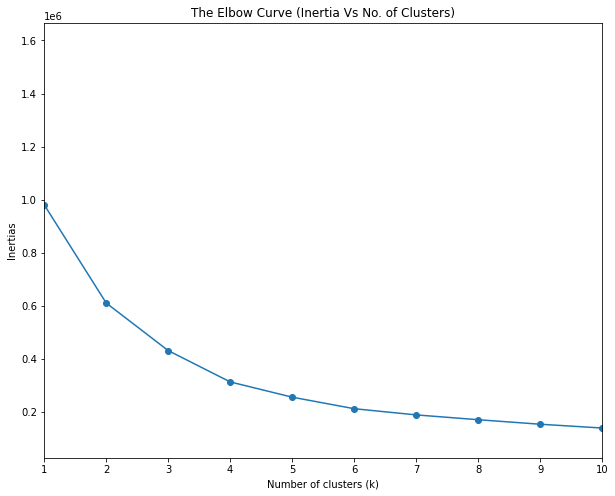

In [36]:
inertias = plot_elbow_curve(df_km, max_clusters = 15)

**The drop in initia from 7 to 8 clusters is not very significant. Let's go with `k = 6` clusters since the number of clusters was not explicitly given in the assignment specification.**
### Train the model with selected number of clusters

In [40]:
model = KMeans(n_clusters = 6, n_init = 15)
clusters = model.fit_predict(df_km)
df_km['clusters'] = clusters + 1
print(df_km.clusters.value_counts())

1    104932
3     91975
2     72103
6     65586
4     63326
5         2
Name: clusters, dtype: int64


### Analyzing Results
Clusters `1, 2, 3, 4` and `6` have relatively sufficient number of candidate or customers. However, Cluster `5` does not have significant number of observations.

In [43]:
print(f'Inertia: {model.inertia_}\n')
print(f'Number of Cluster centroids: {len(model.cluster_centers_)}\n')
print(f'Number of iterations: {model.n_iter_}\n')
print(f'Number of features: {model.n_features_in_}\n')
print(f'Feature names: {model.feature_names_in_}')

Inertia: 259302.86015704094

Number of Cluster centroids: 6

Number of iterations: 5

Number of features: 5

Feature names: ['InvoiceDate' 'Quantity' 'CustomerID' 'InvoiceNo' 'clusters']


In [44]:
df_km.head()

,InvoiceDate,Quantity,CustomerID,InvoiceNo,clusters
0,-1.964314,-0.038919,1.491789,-1.850438,2
1,-1.964314,-0.038919,1.491789,-1.850438,2
2,-1.964314,-0.027834,1.491789,-1.850438,2
3,-1.964314,-0.038919,1.491789,-1.850438,2
4,-1.964314,-0.038919,1.491789,-1.850438,2


### Include the clusters in the Transaction DataFrame
Let's check this distribution of `CustomerID, Country` and `InvoiceNo` in the clusters. 

In [45]:
df['clusters'] = clusters + 1

## Analysing the clusters
For easy plotting, we'll be using a random sample of `1000` observations.
### Cluster Centriods

In [47]:
centroids = pd.DataFrame(model.cluster_centers_, columns = model.feature_names_in_)
centroids

,InvoiceDate,Quantity,CustomerID,InvoiceNo,clusters
0,0.770110,-0.007480,0.922223,0.763979,3.000000
1,-1.014510,-0.005413,1.015944,-1.005536,2.006991
2,0.949852,-0.004264,-0.798468,0.968076,1.000000
3,-1.354891,0.002443,-0.758289,-1.305824,2.000000
4,-0.098067,430.063105,-0.524359,0.064082,4.000000
5,-0.140837,0.008425,-0.740420,-0.213834,1.000000


## Visualize the centriods
Since we cannot easily visualize multi-dimensional features in one chart, we'll be visualising pairs of features in turn. We'll also be using a random sample of `1000` observations from from our DataFrame for faster plotting.

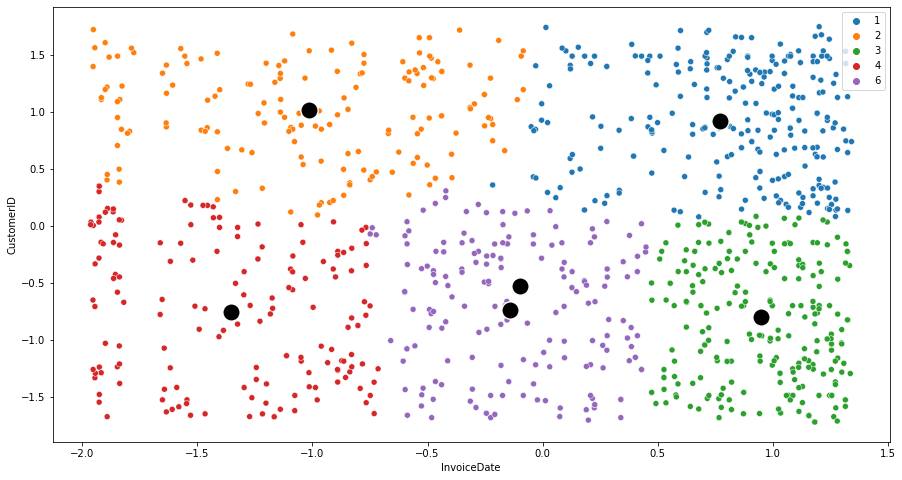

In [48]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.scatterplot(x = 'InvoiceDate', y = 'CustomerID', hue = 'clusters', data = df_km.sample(1000), palette = 'tab10')
sns.scatterplot(x = 'InvoiceDate', y = 'CustomerID', data = centroids, s = 300, c = ['black']);

**The features `InvoiceDate` and `CustomerID` are good features for segmenting the customers into `4` groups.**

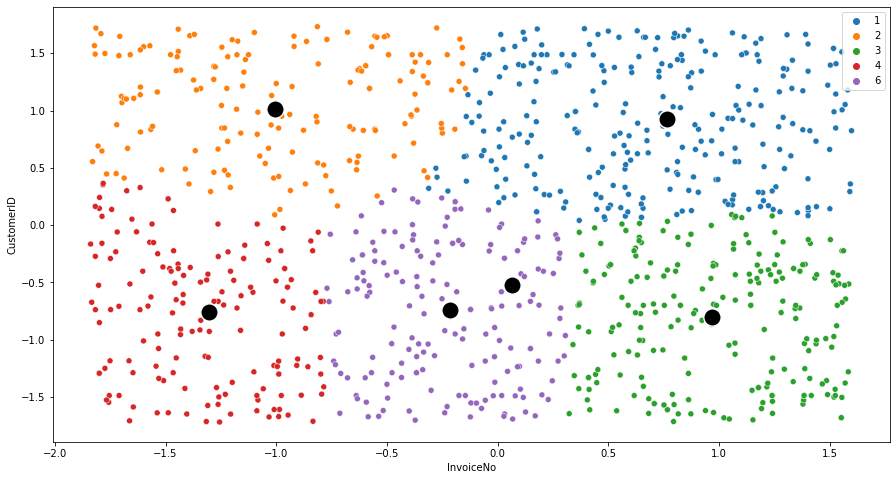

In [49]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.scatterplot(x = 'InvoiceNo', y = 'CustomerID', hue = 'clusters', data = df_km.sample(1000), palette = 'tab10')
sns.scatterplot(x = 'InvoiceNo', y = 'CustomerID', data = centroids, s = 300, c = ['black']);

**The features `InvoiceNo` and `CustomerID` are good features for segmenting the customers into `4` groups.**

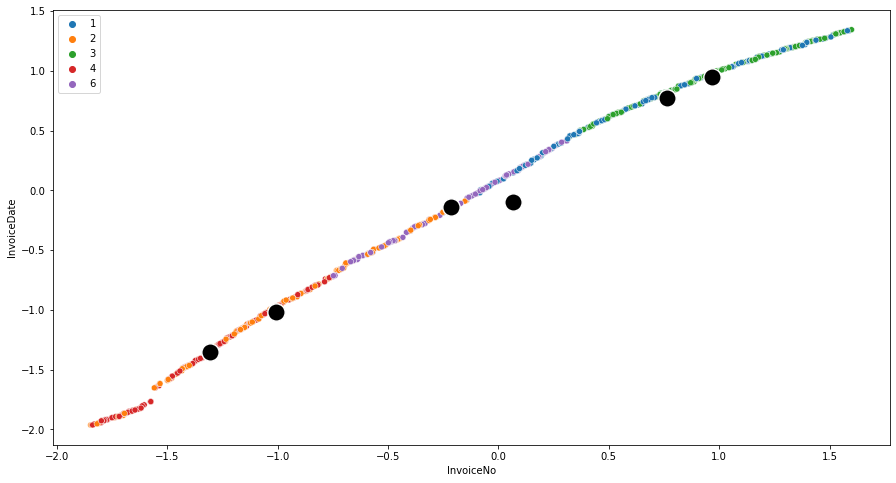

In [51]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.scatterplot(x = 'InvoiceNo', y = 'InvoiceDate', hue = 'clusters', data = df_km.sample(1000), palette = 'tab10')
sns.scatterplot(x = 'InvoiceNo', y = 'InvoiceDate', data = centroids, s = 300, c = ['black']);

**The features `InvoiceNo` and `InvoiceDate` are not so good features for segmenting the customers into `4` groups.**
### Examples of 3D View of the clusters

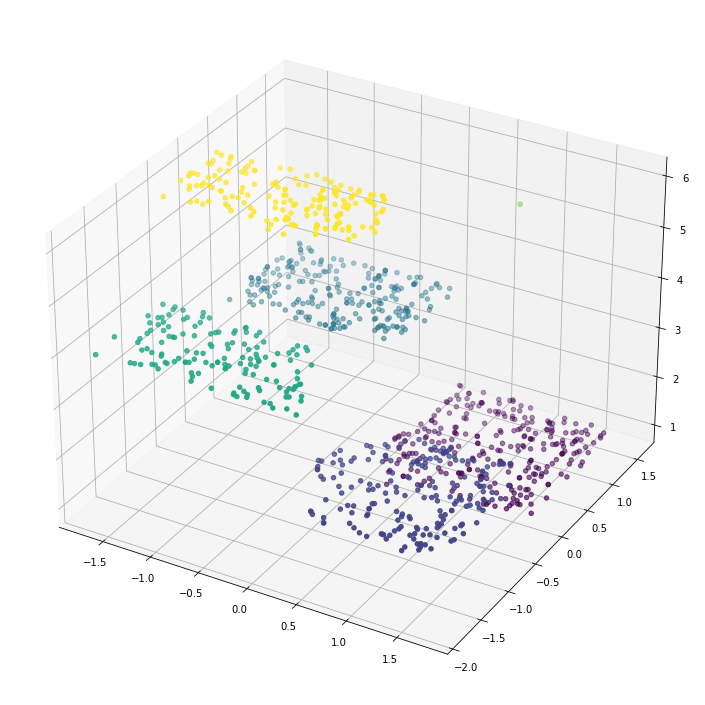

In [52]:
from mpl_toolkits.mplot3d import Axes3D

x, y, z = zip(*df_km.loc[:, ['CustomerID', 'InvoiceNo', 'clusters']].sample(1000).values)
fig = plt.figure(figsize = (15, 6))
ax = plt.axes(projection = '3d')
ax.scatter(x, y, z, c = z)
fig.subplots_adjust(top = 1.5, bottom = -.1)
plt.show()

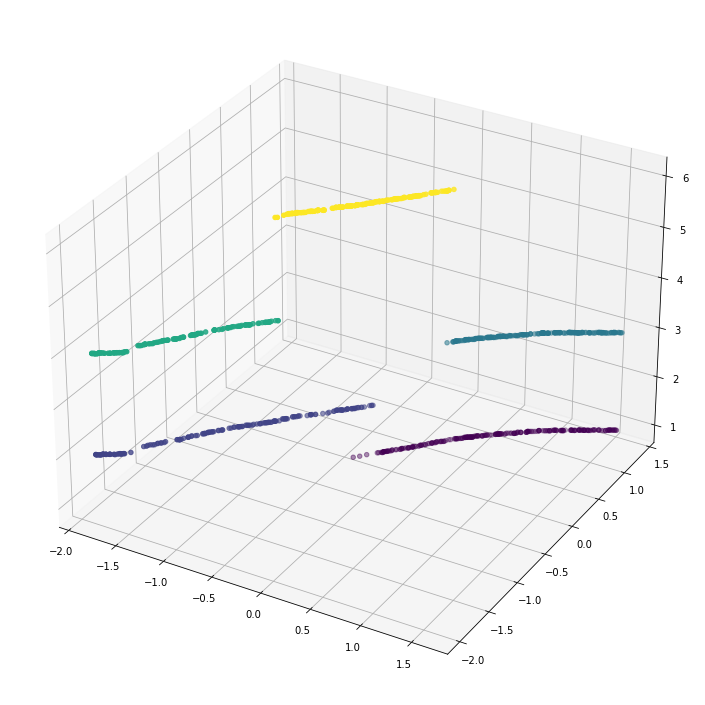

In [53]:
x, y, z = zip(*df_km.loc[:, ['InvoiceNo', 'InvoiceDate', 'clusters']].sample(1000).values)
fig = plt.figure(figsize = (15, 6))
ax = plt.axes(projection = '3d')
ax.scatter(x, y, z, c = z)
fig.subplots_adjust(top = 1.5, bottom = -.1)
plt.show()

## Customer segmentation offers numerous benefits 
The benefits include improved customer retention, more targeted marketing campaigns, enhanced customer satisfaction, and ultimately, increased ROI by focusing efforts on the most profitable segments. 

### Detailed look at the benefits
#### 1. Enhanced Customer Retention and Loyalty:
**Personalized Experiences:** By understanding the needs and preferences of different customer groups, businesses can provide more relevant and meaningful experiences, leading to increased customer satisfaction and loyalty.

**Improved Customer Satisfaction:** Customers who feel understood and valued are more likely to remain loyal to a brand.

**Targeted Marketing:** Segmentation allows businesses to create more relevant and personalized marketing messages, which resonates better with specific customer segments, leading to increased engagement and retention. 

#### 2. Improved Marketing ROI and Efficiency:
**Targeted Campaigns:** Instead of a "one-size-fits-all" approach, segmentation enables businesses to create highly targeted campaigns that resonate with specific segments, leading to improved response rates and conversions. 

**Efficient Resource Allocation:** By focusing efforts on the most profitable customer segments, businesses can allocate resources more efficiently, leading to a higher return on investment (ROI). 

**Optimize Pricing:** Customer segmentation can help businesses optimize pricing for their products and services by understanding the willingness to pay of different customer groups. 

#### 3. Better Understanding of Customer Needs and Behavior:
**Identify Untapped Opportunities:** Segmentation can help businesses identify unmet customer needs and potential opportunities for growth. 

**Improved Product Development:** By understanding the needs and preferences of different customer segments, businesses can develop products and services that better meet those needs. 

**Competitive Advantage:** Understanding your customers better than your competitors can give you a significant competitive advantage. 